In [1]:
import torch
from torch import nn

# Note: this notebook requires torch >= 1.10.0
torch.__version__

'2.7.1+cpu'

In [2]:
import requests
import zipfile
from pathlib import Path

In [3]:
import os

# Setup path to data folder
data_path = Path("F:\Lettuce_leaf_classification\Lettuce_disease_datasets")
# image_path = data_path
print(data_path.is_dir)


def walk_through_dir(dir_path):
    """
    Walks through dir_path returning its contents.
    Args:
      dir_path (str or pathlib.Path): target directory

    Returns:
      A print out of:
        number of subdiretories in dir_path
        number of images (files) in each subdirectory
        name of each subdirectory
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(
            f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'."
        )

<bound method Path.is_dir of WindowsPath('F:/Lettuce_leaf_classification/Lettuce_disease_datasets')>


In [4]:
walk_through_dir(dir_path=data_path)

There are 8 directories and 0 images in 'F:\Lettuce_leaf_classification\Lettuce_disease_datasets'.
There are 0 directories and 1052 images in 'F:\Lettuce_leaf_classification\Lettuce_disease_datasets\BACT'.
There are 0 directories and 819 images in 'F:\Lettuce_leaf_classification\Lettuce_disease_datasets\DML'.
There are 0 directories and 1123 images in 'F:\Lettuce_leaf_classification\Lettuce_disease_datasets\HLTY'.
There are 0 directories and 956 images in 'F:\Lettuce_leaf_classification\Lettuce_disease_datasets\PML'.
There are 0 directories and 1013 images in 'F:\Lettuce_leaf_classification\Lettuce_disease_datasets\SBL'.
There are 0 directories and 1106 images in 'F:\Lettuce_leaf_classification\Lettuce_disease_datasets\SPW'.
There are 0 directories and 1535 images in 'F:\Lettuce_leaf_classification\Lettuce_disease_datasets\VIRL'.
There are 0 directories and 1153 images in 'F:\Lettuce_leaf_classification\Lettuce_disease_datasets\WLBL'.


# -------------------------------------
### neural networks are quite sensitive to class imbalance, especially in image classification tasks. Since we are working with a custom dataset with 8 classes and using PyTorch, here’s a complete pipeline to handle class imbalance effectively, with a focus on both data-level and algorithm-level techniques.


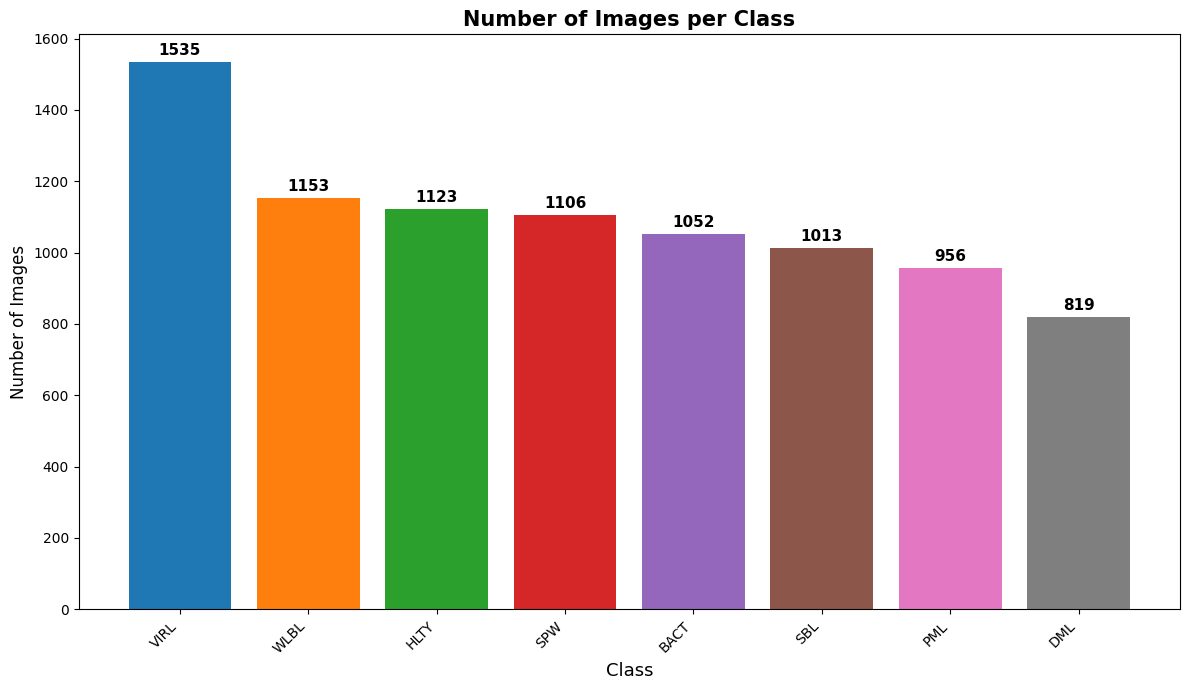

,Class,Image Count
0,VIRL,1535
1,WLBL,1153
2,HLTY,1123
3,SPW,1106
4,BACT,1052
5,SBL,1013
6,PML,956
7,DML,819


In [5]:
import os
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns


from IPython.display import display, Markdown


def plot_image_counts(dataset_dir):
    """








    Visualize the number of images in each class folder as a barplot (descending order),








    and display a DataFrame with the counts. Adds count labels on bars.
    """

    class_folders = [
        d
        for d in os.listdir(dataset_dir)
        if os.path.isdir(os.path.join(dataset_dir, d))
    ]
    class_folders.sort()

    counts = []

    for class_name in class_folders:

        class_path = os.path.join(dataset_dir, class_name)
        n_images = len(
            [
                f
                for f in os.listdir(class_path)
                if os.path.isfile(os.path.join(class_path, f))
            ]
        )
        counts.append(n_images)

    # Create DataFrame and sort descending

    df = pd.DataFrame({"Class": class_folders, "Image Count": counts})

    df = df.sort_values("Image Count", ascending=False).reset_index(drop=True)

    # Plot

    plt.figure(figsize=(12, 7))

    palette = sns.color_palette("tab10", n_colors=len(df))

    bars = plt.bar(df["Class"], df["Image Count"], color=palette)

    plt.xlabel("Class", fontsize=13)

    plt.ylabel("Number of Images", fontsize=12)

    plt.title("Number of Images per Class", fontsize=15, fontweight="bold")

    plt.xticks(rotation=45, ha="right")

    # Add count labels on top of bars

    for bar in bars:
        height = bar.get_height()
        plt.annotate(
            f"{int(height)}",
            xy=(bar.get_x() + bar.get_width() / 2, height),
            xytext=(0, 3),
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=11,
            fontweight="bold",
        )

    plt.tight_layout()

    plt.show()

    display(df)


# Example usage:


plot_image_counts(r"F:\Lettuce_leaf_classification\Lettuce_disease_datasets")

In [6]:
import os
import random
from PIL import Image
from torchvision import transforms


class ImageAugmentor:
    def __init__(self, directory, augment_fraction=0.25, output_format="JPEG"):
        self.directory = directory
        self.augment_fraction = augment_fraction
        self.output_format = output_format.upper()

        # Define transformation pipeline
        self.transform = transforms.Compose(
            [
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(10),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
                transforms.ToTensor(),
            ]
        )

    def get_image_files(self):
        """Returns list of image files in the directory"""
        return [
            f
            for f in os.listdir(self.directory)
            if f.lower().endswith((".png", ".jpg", ".jpeg"))
        ]

    def augment_images(self):
        """Performs augmentation on a fraction of images and saves to the same directory"""
        image_files = self.get_image_files()
        num_images = len(image_files)
        num_to_augment = int(self.augment_fraction * num_images)

        print(f"Found {num_images} images. Augmenting {num_to_augment} images...")

        selected_files = random.sample(image_files, num_to_augment)

        for idx, filename in enumerate(selected_files):
            file_path = os.path.join(self.directory, filename)
            with Image.open(file_path) as img:
                img = img.convert("RGB")
                augmented_tensor = self.transform(img)
                augmented_img = transforms.ToPILImage()(augmented_tensor)

                new_filename = f"{os.path.splitext(filename)[0]}_aug{idx}.jpg"
                new_path = os.path.join(self.directory, new_filename)
                augmented_img.save(new_path, format=self.output_format)

        print(
            f"✅ Augmented {num_to_augment} images. Total images should now be ~{num_images + num_to_augment}."
        )

In [7]:
class_folder_path = "F:\Lettuce_leaf_classification\Lettuce_disease_datasets\WLBL"  # WLBL (initially have only 6 images now)
augmenter = ImageAugmentor(directory=class_folder_path, augment_fraction=0.25)
augmenter.augment_images()

Found 1153 images. Augmenting 288 images...
✅ Augmented 288 images. Total images should now be ~1441.


In [8]:
class_folder_path = "F:\Lettuce_leaf_classification\Lettuce_disease_datasets\WLBL"  # WLBL (initially have only 6 images now)
augmenter = ImageAugmentor(directory=class_folder_path, augment_fraction=0.85)
augmenter.augment_images()

Found 1441 images. Augmenting 1224 images...
✅ Augmented 1224 images. Total images should now be ~2665.


In [9]:
class_folder_path = "F:\Lettuce_leaf_classification\Lettuce_disease_datasets\WLBL"  # WLBL (initially have only 6 images now)
augmenter = ImageAugmentor(directory=class_folder_path, augment_fraction=0.95)
augmenter.augment_images()

Found 2665 images. Augmenting 2531 images...
✅ Augmented 2531 images. Total images should now be ~5196.


### Reached after several rerun command . Now the WLBL class has 1154 random images.
    ### Now , I will use the above function for other minority classes to bring their counts of the oder of 10^3

In [10]:
class_folder_path = (
    "F:\Lettuce_leaf_classification\Lettuce_disease_datasets\VIRL"  # VIRL (2nd )
)
augmenter = ImageAugmentor(directory=class_folder_path, augment_fraction=0.95)
augmenter.augment_images()

Found 1535 images. Augmenting 1458 images...
✅ Augmented 1458 images. Total images should now be ~2993.


In [11]:
class_folder_path = (
    "F:\Lettuce_leaf_classification\Lettuce_disease_datasets\PML"  # PML (3rd )
)
augmenter = ImageAugmentor(directory=class_folder_path, augment_fraction=0.95)
augmenter.augment_images()

Found 956 images. Augmenting 908 images...
✅ Augmented 908 images. Total images should now be ~1864.


In [12]:
class_folder_path = (
    "F:\Lettuce_leaf_classification\Lettuce_disease_datasets\SBL"  # SBL (4th )
)
augmenter = ImageAugmentor(directory=class_folder_path, augment_fraction=0.95)
augmenter.augment_images()

Found 1013 images. Augmenting 962 images...
✅ Augmented 962 images. Total images should now be ~1975.


In [13]:
class_folder_path = (
    "F:\Lettuce_leaf_classification\Lettuce_disease_datasets\BACT"  # BACT (5th )
)
augmenter = ImageAugmentor(directory=class_folder_path, augment_fraction=0.95)
augmenter.augment_images()

Found 1052 images. Augmenting 999 images...


KeyboardInterrupt: 

In [ ]:
class_folder_path = (
    "F:\Lettuce_leaf_classification\Lettuce_disease_datasets\DML"  # DML (6th )
)
augmenter = ImageAugmentor(directory=class_folder_path, augment_fraction=0.95)
augmenter.augment_images()

Found 420 images. Augmenting 399 images...
✅ Augmented 399 images. Total images should now be ~819.


## Now Lets Again visualize the count plot for images in the dataset folder

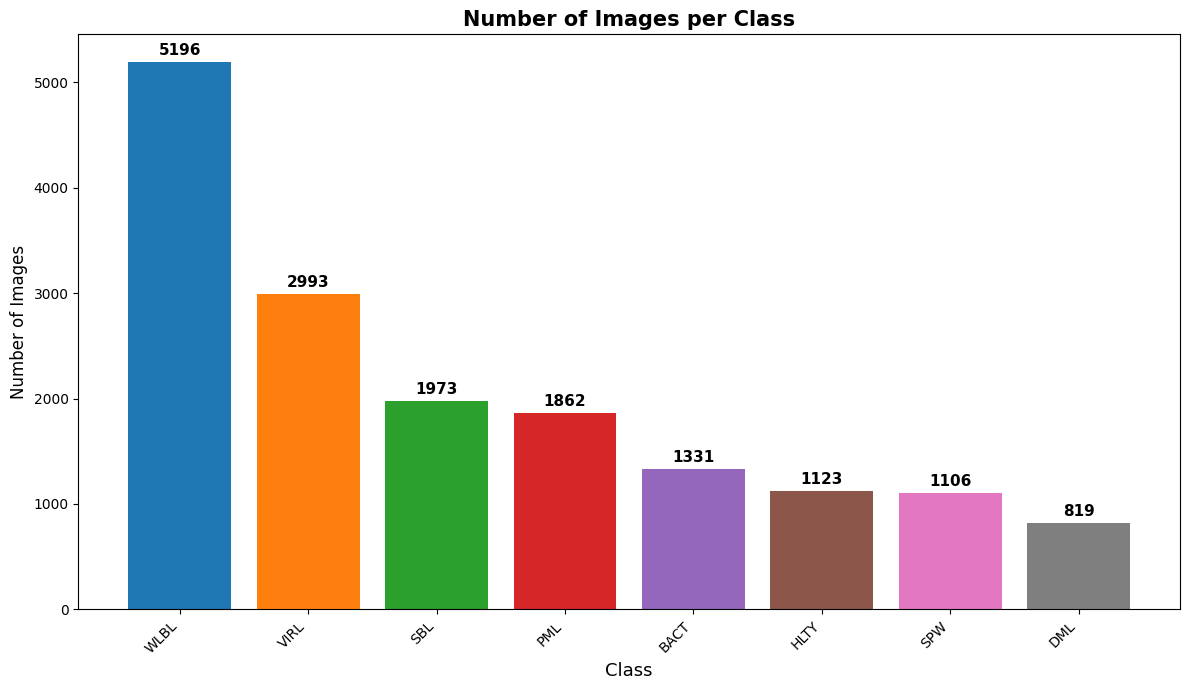

,Class,Image Count
0,WLBL,5196
1,VIRL,2993
2,SBL,1973
3,PML,1862
4,BACT,1331
5,HLTY,1123
6,SPW,1106
7,DML,819


In [14]:
plot_image_counts(r"F:\Lettuce_leaf_classification\Lettuce_disease_datasets")

In [ ]:
!pip install tqdm

  Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)


You should consider upgrading via the 'F:\Lettuce_leaf_classification\Lettuce_leaf_classification\leaf_classf\Scripts\python.exe -m pip install --upgrade pip' command.


In [15]:
import os
import random
import shutil
import math
from tqdm import tqdm


def split_train_test(source_dir, output_dir, train_ratio=0.8, seed=42):
    """
    Split images from class folders into train and test sets (80-20 default).

    Args:
        source_dir (str): Path to the original dataset directory with class subfolders.
        output_dir (str): Output directory where 'train' and 'test' folders will be created.
        train_ratio (float): Ratio of images to use for training.
        seed (int): Random seed for reproducibility.
    """
    try:
        assert os.path.isdir(
            source_dir
        ), f"Source directory '{source_dir}' does not exist."
        assert math.isclose(
            train_ratio, 0.8, rel_tol=1e-6
        ), "Only 80-20 split is supported in this version."

        random.seed(seed)

        class_names = [
            d
            for d in os.listdir(source_dir)
            if os.path.isdir(os.path.join(source_dir, d))
        ]
        if not class_names:
            raise ValueError("No class folders found in the source directory.")

        for split in ["train", "test"]:
            for class_name in class_names:
                split_class_dir = os.path.join(output_dir, split, class_name)
                os.makedirs(split_class_dir, exist_ok=True)

        for class_name in tqdm(class_names, desc="Splitting classes"):
            class_dir = os.path.join(source_dir, class_name)
            image_files = [
                f
                for f in os.listdir(class_dir)
                if f.lower().endswith((".jpg", ".jpeg", ".png"))
            ]

            if len(image_files) < 2:
                print(
                    f"⚠️ Not enough images in class '{class_name}' to split. Skipping."
                )
                continue

            random.shuffle(image_files)
            split_index = int(train_ratio * len(image_files))
            train_imgs = image_files[:split_index]
            test_imgs = image_files[split_index:]

            for img_name in train_imgs:
                src = os.path.join(class_dir, img_name)
                dst = os.path.join(output_dir, "train", class_name, img_name)
                shutil.copy2(src, dst)

            for img_name in test_imgs:
                src = os.path.join(class_dir, img_name)
                dst = os.path.join(output_dir, "test", class_name, img_name)
                shutil.copy2(src, dst)

        print("\n✅ Dataset split completed. 80% train / 20% test per class.")

    except Exception as e:
        print(f"❌ Error during split: {str(e)}")

In [ ]:
source_dataset = (
    "F:\Lettuce_leaf_classification\Lettuce_disease_datasets"  # where 8 folders exist
)
target_dataset = "F:\Lettuce_leaf_classification\DNN_dataloader"  # will contain train/val/test folders

split_train_test(source_dataset, target_dataset)

Splitting classes: 100%|██████████| 8/8 [00:47<00:00,  5.90s/it]


✅ Dataset split completed. 80% train / 20% test per class.


In [16]:
image_path = "F:\Lettuce_leaf_classification\DNN_dataloader"

In [18]:
import os


def walk_through_dir(dir_path):
    """
    Walks through dir_path returning its contents.
    Args:
      dir_path (str or pathlib.Path): target directory

    Returns:
      A print out of:
        number of subdiretories in dir_path
        number of images (files) in each subdirectory
        name of each subdirectory
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(
            f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'."
        )

In [19]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'F:\Lettuce_leaf_classification\DNN_dataloader'.
There are 8 directories and 0 images in 'F:\Lettuce_leaf_classification\DNN_dataloader\test'.
There are 0 directories and 211 images in 'F:\Lettuce_leaf_classification\DNN_dataloader\test\BACT'.
There are 0 directories and 164 images in 'F:\Lettuce_leaf_classification\DNN_dataloader\test\DML'.
There are 0 directories and 225 images in 'F:\Lettuce_leaf_classification\DNN_dataloader\test\HLTY'.
There are 0 directories and 192 images in 'F:\Lettuce_leaf_classification\DNN_dataloader\test\PML'.
There are 0 directories and 203 images in 'F:\Lettuce_leaf_classification\DNN_dataloader\test\SBL'.
There are 0 directories and 222 images in 'F:\Lettuce_leaf_classification\DNN_dataloader\test\SPW'.
There are 0 directories and 307 images in 'F:\Lettuce_leaf_classification\DNN_dataloader\test\VIRL'.
There are 0 directories and 231 images in 'F:\Lettuce_leaf_classification\DNN_dataloader\test\WLBL'.
There are 8 d

In [21]:
from pathlib import Path

image_path = Path(image_path)
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('F:/Lettuce_leaf_classification/DNN_dataloader/train'),
 WindowsPath('F:/Lettuce_leaf_classification/DNN_dataloader/test'))

Random image path: F:\Lettuce_leaf_classification\DNN_dataloader\train\BACT\BACT_10_aug17_aug21_aug23_aug87_aug415.jpg
Image class: BACT
Image height: 396
Image width: 263


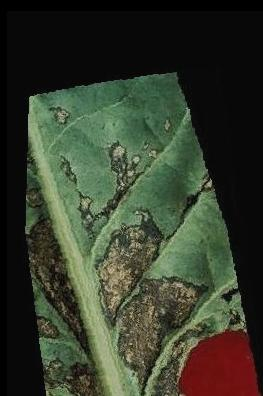

In [22]:
import random
from PIL import Image

# Set seed
random.seed(42)  # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

(np.float64(-0.5), np.float64(262.5), np.float64(395.5), np.float64(-0.5))

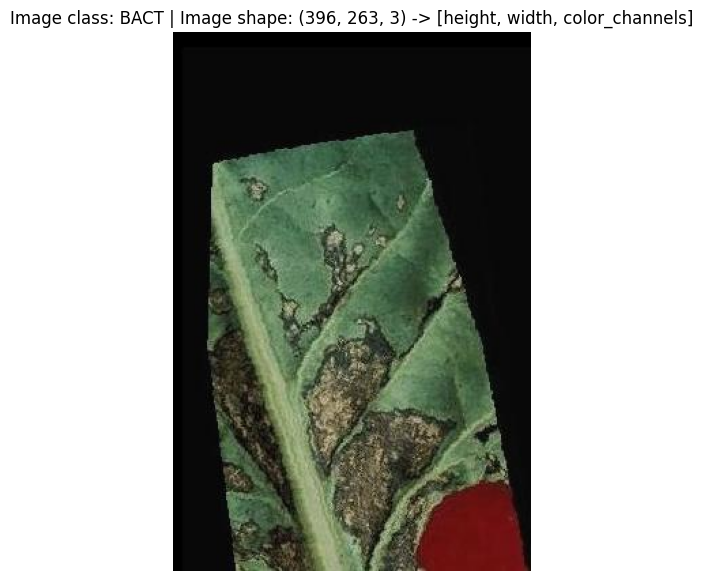

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(
    f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]"
)
plt.axis(False)

## 3. Transforming data 

Now what if we wanted to load our image data into PyTorch?

Before we can use our image data with PyTorch we need to:

1. Turn it into tensors (numerical representations of our images).
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader` for short.


In [24]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

We've got folders of images but before we can use them with PyTorch, we need to convert them into tensors.

One of the ways we can do this is by using the `torchvision.transforms` module.

`torchvision.transforms` contains many pre-built methods for formatting images, turning them into tensors and even manipulating them for **data augmentation** (the practice of altering data to make it harder for a model to learn, we'll see this later on) purposes . 

To get experience with `torchvision.transforms`, let's write a series of transform steps that:
1. Resize the images using [`transforms.Resize()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Resize.html#torchvision.transforms.Resize) (from about 512x512 to 64x64, the same shape as the images on the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/)).
2. Flip our images randomly on the horizontal using [`transforms.RandomHorizontalFlip()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomHorizontalFlip.html#torchvision.transforms.RandomHorizontalFlip) (this could be considered a form of data augmentation because it will artificially change our image data).
3. Turn our images from a PIL image to a PyTorch tensor using [`transforms.ToTensor()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html#torchvision.transforms.ToTensor).

We can compile all of these steps using [`torchvision.transforms.Compose()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose).

In [25]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [26]:
# Write transform for image
data_transform = transforms.Compose(
    [
        # Resize the images to 64x64
        transforms.Resize(size=(64, 64)),
        # Flip the images randomly on the horizontal
        transforms.RandomHorizontalFlip(
            p=0.5
        ),  # p = probability of flip, 0.5 = 50% chance
        # Turn the image into a torch.Tensor
        transforms.ToTensor(),  # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
    ]
)

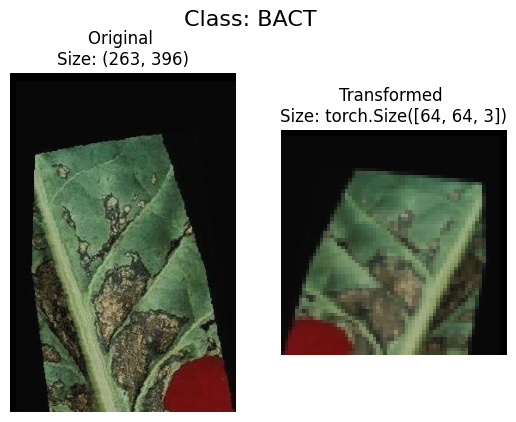

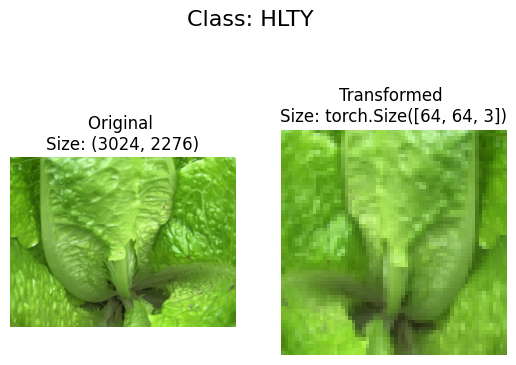

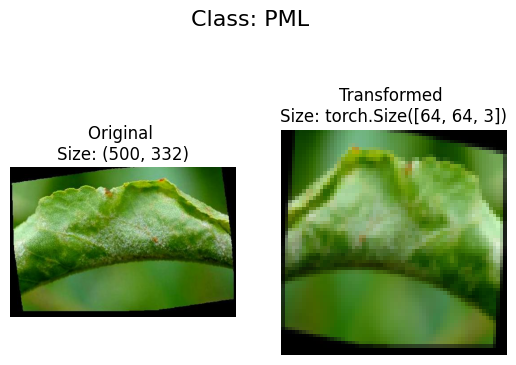

In [27]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)


plot_transformed_images(image_path_list, transform=data_transform, n=3)

## 4. Loading Image Data Using [`ImageFolder`](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder)

Alright, time to turn our image data into a `Dataset` capable of being used with PyTorch.


In [28]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets

train_data = datasets.ImageFolder(
    root=train_dir,  # target folder of images
    transform=data_transform,  # transforms to perform on data (images)
    target_transform=None,
)  # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 7002
    Root location: F:\Lettuce_leaf_classification\DNN_dataloader\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 1755
    Root location: F:\Lettuce_leaf_classification\DNN_dataloader\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [29]:
# Get class names as a list
class_names = train_data.classes
class_names

['BACT', 'DML', 'HLTY', 'PML', 'SBL', 'SPW', 'VIRL', 'WLBL']

In [30]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'BACT': 0,
 'DML': 1,
 'HLTY': 2,
 'PML': 3,
 'SBL': 4,
 'SPW': 5,
 'VIRL': 6,
 'WLBL': 7}

In [31]:
# Check the lengths
len(train_data), len(test_data)

(7002, 1755)

### Turn Images to Tensor()

In [32]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.0000, 0.0000, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0000, 0.0000, 0.0039,  ..., 0.0196, 0.0235, 0.0196],
         [0.0000, 0.0000, 0.0039,  ..., 0.0627, 0.0588, 0.0627],
         ...,
         [0.0000, 0.0000, 0.0039,  ..., 0.3725, 0.3176, 0.2863],
         [0.0000, 0.0000, 0.0039,  ..., 0.2157, 0.1255, 0.1020],
         [0.0000, 0.0000, 0.0039,  ..., 0.0235, 0.0196, 0.0196]],

        [[0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0039,  ..., 0.0314, 0.0353, 0.0353],
         [0.0000, 0.0000, 0.0039,  ..., 0.0941, 0.1020, 0.1020],
         ...,
         [0.0000, 0.0000, 0.0039,  ..., 0.3216, 0.2745, 0.2431],
         [0.0000, 0.0000, 0.0039,  ..., 0.1804, 0.0980, 0.0784],
         [0.0000, 0.0000, 0.0039,  ..., 0.0078, 0.0118, 0.0118]],

        [[0.0000, 0.0000, 0.0039,  ..., 0.0078, 0.0078, 0.0078],
         [0.0000, 0.0000, 0.0039,  ..., 0.0157, 0.0196, 0.0196],
         [0.0000, 0.0000, 0.0039,  ..., 0.05

Our images are now in the form of a tensor (with shape `[3, 64, 64]`) and the labels are in the form of an integer relating to a specific class (as referenced by the `class_to_idx` attribute).

How about we plot a single image tensor using `matplotlib`?

We'll first have to to permute (rearrange the order of its dimensions) so it's compatible.

Right now our image dimensions are in the format `CHW` (color channels, height, width) but `matplotlib` prefers `HWC` (height, width, color channels).

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'BACT')

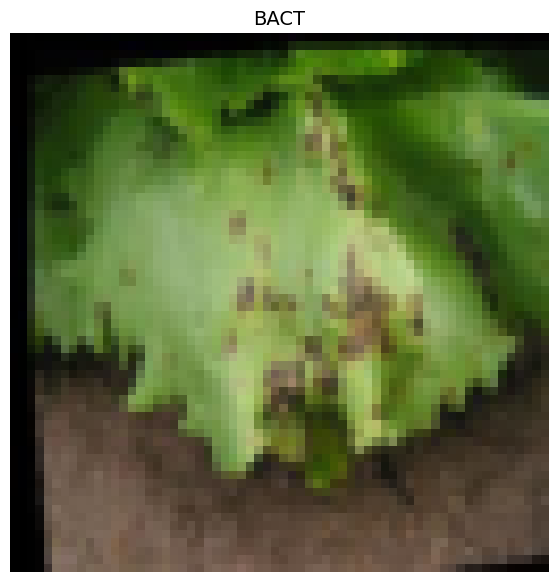

In [33]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14)

### 4.1 Turn loaded images into `DataLoader`'s

We've got our images as PyTorch `Dataset`'s but now let's turn them into `DataLoader`'s.

We'll do so using [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).

Turning our `Dataset`'s into `DataLoader`'s makes them iterable so a model can go through and learn the relationships between samples and targets (features and labels).

To keep things simple, we'll use a `batch_size=1` and `num_workers=1`.

What's `num_workers`?

Good question.

It defines how many subprocesses will be created to load your data.

Think of it like this, the higher value `num_workers` is set to, the more compute power PyTorch will use to load your data.


In [34]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=1,  # how many samples per batch?
    num_workers=1,  # how many subprocesses to use for data loading? (higher = more)
    shuffle=True,
)  # shuffle the data?

test_dataloader = DataLoader(
    dataset=test_data, batch_size=1, num_workers=1, shuffle=False
)  # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x16b6924c820>,
 <torch.utils.data.dataloader.DataLoader at 0x16b6859a830>)

In [35]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 7. Experimentig Model 0: TinyVGG without data augmentation

Alright, we've seen how to turn our data from images in folders to transformed tensors.

Now let's construct a computer vision model to see if we can classify if an image is of pizza, steak or sushi.

To begin, we'll start with a simple transform, only resizing the images to `(64, 64)` and turning them into tensors.

### 7.1 Data tranform 

In [36]:
# Create simple transform
simple_transform = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
    ]
)

In [37]:
# 1. Load and transform data
from torchvision import datasets

train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# 2. Turn data into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers
BATCH_SIZE = 8
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader_simple = DataLoader(
    train_data_simple, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS
)

test_dataloader_simple = DataLoader(
    test_data_simple, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
)

train_dataloader_simple, test_dataloader_simple

Creating DataLoader's with batch size 8 and 12 workers.


(<torch.utils.data.dataloader.DataLoader at 0x16b6859aec0>,
 <torch.utils.data.dataloader.DataLoader at 0x16b6957ac50>)

### 7.2 Create TinyVGG model class

In [notebook 03](https://www.learnpytorch.io/03_pytorch_computer_vision/#7-model-2-building-a-convolutional-neural-network-cnn), we used the TinyVGG model from the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/).

Let's recreate the same model, except this time we'll be using color images instead of grayscale (`in_channels=3` instead of `in_channels=1` for RGB pixels). 

In [ ]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """

    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,  # how big is the square that's going over the image?
                stride=1,  # default
                padding=1,
            ),  # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2, stride=2
            ),  # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units * 16 * 16, out_features=output_shape),
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion


torch.manual_seed(42)
model_0 = TinyVGG(
    input_shape=3,  # number of color channels (3 for RGB)
    hidden_units=10,
    output_shape=len(train_data.classes),
).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=8, bias=True)
  )
)

### 7.4 torchinfo for summary and evaluation


In [39]:
# Install torchinfo if it's not available, import it if it is
try: 
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
    
from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64]) # do a test pass through of an example input size 

  Using cached torchinfo-1.8.0-py3-none-any.whl (23 kB)


You should consider upgrading via the 'F:\Lettuce_leaf_classification\Lettuce_leaf_classification\leaf_classf\Scripts\python.exe -m pip install --upgrade pip' command.


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 8]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

### 7.5 Create train & test loop functions 

We've got data and we've got a model.

Now let's make some training and test loop functions to train our model on the training data and evaluate our model on the testing data.

And to make sure we can use these the training and testing loops again, we'll functionize them.

Specifically, we're going to make three functions:
1. `train_step()` - takes in a model, a `DataLoader`, a loss function and an optimizer and trains the model on the `DataLoader`.
2. `test_step()` - takes in a model, a `DataLoader` and a loss function and evaluates the model on the `DataLoader`.
3. `train()` - performs 1. and 2. together for a given number of epochs and returns a results dictionary.


In [ ]:
def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [ ]:
def test_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [ ]:
from tqdm.auto import tqdm


# 1. Take in various parameters required for training and test steps
def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
    epochs: int = 5,
):

    # 2. Create empty results dictionary
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
        )
        test_loss, test_acc = test_step(
            model=model, dataloader=test_dataloader, loss_fn=loss_fn
        )

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(
            train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss
        )
        results["train_acc"].append(
            train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc
        )
        results["test_loss"].append(
            test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss
        )
        results["test_acc"].append(
            test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc
        )

    # 6. Return the filled results at the end of the epochs
    return results

f:\Lettuce_leaf_classification\Lettuce_leaf_classification\leaf_classf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 15

# Recreate an instance of TinyVGG
model_0 = TinyVGG(
    input_shape=3,  # number of color channels (3 for RGB)
    hidden_units=10,
    output_shape=len(train_data.classes),
).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer

start_time = timer()

# Train model_0
model_0_results = train(
    model=model_0,
    train_dataloader=train_dataloader_simple,
    test_dataloader=test_dataloader_simple,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=NUM_EPOCHS,
)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:08<?, ?it/s]


KeyboardInterrupt: 

In [46]:
NUM_EPOCHS = 50

  2%|▏         | 1/50 [02:35<2:07:01, 155.55s/it]

Epoch: 1 | train_loss: 1.3997 | train_acc: 0.4502 | test_loss: 1.0516 | test_acc: 0.6170


  4%|▍         | 2/50 [04:49<1:54:10, 142.73s/it]

Epoch: 2 | train_loss: 0.9179 | train_acc: 0.6655 | test_loss: 0.8718 | test_acc: 0.6833


  6%|▌         | 3/50 [07:07<1:50:02, 140.47s/it]

Epoch: 3 | train_loss: 0.7463 | train_acc: 0.7327 | test_loss: 0.7380 | test_acc: 0.7282


  8%|▊         | 4/50 [09:20<1:45:36, 137.75s/it]

Epoch: 4 | train_loss: 0.6343 | train_acc: 0.7757 | test_loss: 0.6824 | test_acc: 0.7786


 10%|█         | 5/50 [11:36<1:42:52, 137.16s/it]

Epoch: 5 | train_loss: 0.5403 | train_acc: 0.8071 | test_loss: 0.6280 | test_acc: 0.7725


 12%|█▏        | 6/50 [13:55<1:40:57, 137.68s/it]

Epoch: 6 | train_loss: 0.4834 | train_acc: 0.8243 | test_loss: 0.7464 | test_acc: 0.7593


 14%|█▍        | 7/50 [16:09<1:37:55, 136.64s/it]

Epoch: 7 | train_loss: 0.4208 | train_acc: 0.8456 | test_loss: 0.6549 | test_acc: 0.7765


 16%|█▌        | 8/50 [18:22<1:34:43, 135.32s/it]

Epoch: 8 | train_loss: 0.3824 | train_acc: 0.8594 | test_loss: 0.7056 | test_acc: 0.7769


 18%|█▊        | 9/50 [20:32<1:31:18, 133.61s/it]

Epoch: 9 | train_loss: 0.3458 | train_acc: 0.8737 | test_loss: 0.6281 | test_acc: 0.8025


 20%|██        | 10/50 [22:41<1:28:05, 132.15s/it]

Epoch: 10 | train_loss: 0.3188 | train_acc: 0.8880 | test_loss: 0.6726 | test_acc: 0.7799


 22%|██▏       | 11/50 [24:50<1:25:18, 131.24s/it]

Epoch: 11 | train_loss: 0.2772 | train_acc: 0.8963 | test_loss: 0.5690 | test_acc: 0.8231


 24%|██▍       | 12/50 [27:02<1:23:15, 131.47s/it]

Epoch: 12 | train_loss: 0.2708 | train_acc: 0.9035 | test_loss: 0.5549 | test_acc: 0.8263


 26%|██▌       | 13/50 [29:11<1:20:40, 130.82s/it]

Epoch: 13 | train_loss: 0.2314 | train_acc: 0.9161 | test_loss: 0.6485 | test_acc: 0.8047


 28%|██▊       | 14/50 [31:23<1:18:39, 131.10s/it]

Epoch: 14 | train_loss: 0.2160 | train_acc: 0.9237 | test_loss: 0.6271 | test_acc: 0.8121


 30%|███       | 15/50 [33:32<1:16:07, 130.51s/it]

Epoch: 15 | train_loss: 0.2070 | train_acc: 0.9241 | test_loss: 0.6434 | test_acc: 0.8127


 32%|███▏      | 16/50 [35:44<1:14:14, 131.01s/it]

Epoch: 16 | train_loss: 0.1558 | train_acc: 0.9453 | test_loss: 0.6809 | test_acc: 0.8320


 34%|███▍      | 17/50 [37:54<1:11:53, 130.72s/it]

Epoch: 17 | train_loss: 0.1594 | train_acc: 0.9428 | test_loss: 0.9308 | test_acc: 0.7788


 36%|███▌      | 18/50 [40:06<1:09:51, 130.99s/it]

Epoch: 18 | train_loss: 0.1576 | train_acc: 0.9448 | test_loss: 0.6880 | test_acc: 0.8189


 38%|███▊      | 19/50 [42:16<1:07:30, 130.68s/it]

Epoch: 19 | train_loss: 0.1437 | train_acc: 0.9485 | test_loss: 0.7086 | test_acc: 0.8235


 40%|████      | 20/50 [44:26<1:05:18, 130.62s/it]

Epoch: 20 | train_loss: 0.1147 | train_acc: 0.9622 | test_loss: 0.9067 | test_acc: 0.8038


 42%|████▏     | 21/50 [46:38<1:03:17, 130.94s/it]

Epoch: 21 | train_loss: 0.1140 | train_acc: 0.9596 | test_loss: 0.7743 | test_acc: 0.8326


 44%|████▍     | 22/50 [48:51<1:01:21, 131.49s/it]

Epoch: 22 | train_loss: 0.1240 | train_acc: 0.9588 | test_loss: 0.7743 | test_acc: 0.8235


 46%|████▌     | 23/50 [51:01<58:56, 130.98s/it]  

Epoch: 23 | train_loss: 0.0875 | train_acc: 0.9690 | test_loss: 0.9561 | test_acc: 0.8095


 48%|████▊     | 24/50 [53:10<56:30, 130.40s/it]

Epoch: 24 | train_loss: 0.0993 | train_acc: 0.9658 | test_loss: 0.9277 | test_acc: 0.8172


 50%|█████     | 25/50 [55:18<54:03, 129.73s/it]

Epoch: 25 | train_loss: 0.1089 | train_acc: 0.9660 | test_loss: 0.8707 | test_acc: 0.8252


 52%|█████▏    | 26/50 [57:26<51:44, 129.37s/it]

Epoch: 26 | train_loss: 0.0757 | train_acc: 0.9749 | test_loss: 0.9479 | test_acc: 0.8269


 54%|█████▍    | 27/50 [59:35<49:30, 129.14s/it]

Epoch: 27 | train_loss: 0.0950 | train_acc: 0.9720 | test_loss: 0.9407 | test_acc: 0.8178


 56%|█████▌    | 28/50 [1:01:46<47:33, 129.72s/it]

Epoch: 28 | train_loss: 0.0731 | train_acc: 0.9746 | test_loss: 1.0484 | test_acc: 0.8220


 58%|█████▊    | 29/50 [1:03:56<45:25, 129.78s/it]

Epoch: 29 | train_loss: 0.1000 | train_acc: 0.9669 | test_loss: 0.9975 | test_acc: 0.8271


 60%|██████    | 30/50 [1:06:06<43:15, 129.79s/it]

Epoch: 30 | train_loss: 0.0789 | train_acc: 0.9762 | test_loss: 0.9983 | test_acc: 0.8263


 62%|██████▏   | 31/50 [1:08:14<40:58, 129.40s/it]

Epoch: 31 | train_loss: 0.0608 | train_acc: 0.9809 | test_loss: 1.0588 | test_acc: 0.8155


 64%|██████▍   | 32/50 [1:10:23<38:47, 129.30s/it]

Epoch: 32 | train_loss: 0.0894 | train_acc: 0.9706 | test_loss: 1.0171 | test_acc: 0.8366


 66%|██████▌   | 33/50 [1:12:32<36:34, 129.08s/it]

Epoch: 33 | train_loss: 0.0578 | train_acc: 0.9810 | test_loss: 1.0361 | test_acc: 0.8229


 68%|██████▊   | 34/50 [1:14:41<34:23, 128.96s/it]

Epoch: 34 | train_loss: 0.0597 | train_acc: 0.9810 | test_loss: 1.0674 | test_acc: 0.8223


 70%|███████   | 35/50 [1:16:57<32:47, 131.17s/it]

Epoch: 35 | train_loss: 0.0504 | train_acc: 0.9833 | test_loss: 1.5950 | test_acc: 0.7884


 72%|███████▏  | 36/50 [1:19:07<30:31, 130.84s/it]

Epoch: 36 | train_loss: 0.0775 | train_acc: 0.9723 | test_loss: 1.1873 | test_acc: 0.8320


 74%|███████▍  | 37/50 [1:21:15<28:11, 130.14s/it]

Epoch: 37 | train_loss: 0.0659 | train_acc: 0.9793 | test_loss: 1.1985 | test_acc: 0.8093


 76%|███████▌  | 38/50 [1:23:25<25:58, 129.88s/it]

Epoch: 38 | train_loss: 0.0570 | train_acc: 0.9822 | test_loss: 1.1899 | test_acc: 0.8337


 78%|███████▊  | 39/50 [1:25:33<23:42, 129.35s/it]

Epoch: 39 | train_loss: 0.0337 | train_acc: 0.9892 | test_loss: 1.2036 | test_acc: 0.8339


 80%|████████  | 40/50 [1:27:41<21:31, 129.10s/it]

Epoch: 40 | train_loss: 0.0821 | train_acc: 0.9765 | test_loss: 1.3099 | test_acc: 0.8076


 82%|████████▏ | 41/50 [1:29:51<19:24, 129.35s/it]

Epoch: 41 | train_loss: 0.0602 | train_acc: 0.9780 | test_loss: 1.2635 | test_acc: 0.8246


 84%|████████▍ | 42/50 [1:32:04<17:23, 130.46s/it]

Epoch: 42 | train_loss: 0.0587 | train_acc: 0.9813 | test_loss: 1.3378 | test_acc: 0.8174


 86%|████████▌ | 43/50 [1:34:13<15:09, 129.94s/it]

Epoch: 43 | train_loss: 0.0463 | train_acc: 0.9842 | test_loss: 1.3641 | test_acc: 0.8212


 88%|████████▊ | 44/50 [1:36:23<12:59, 129.88s/it]

Epoch: 44 | train_loss: 0.0561 | train_acc: 0.9850 | test_loss: 1.7129 | test_acc: 0.7890


 90%|█████████ | 45/50 [1:38:31<10:46, 129.39s/it]

Epoch: 45 | train_loss: 0.0695 | train_acc: 0.9797 | test_loss: 1.3950 | test_acc: 0.8112


 92%|█████████▏| 46/50 [1:40:40<08:36, 129.15s/it]

Epoch: 46 | train_loss: 0.0378 | train_acc: 0.9874 | test_loss: 1.3923 | test_acc: 0.8163


 94%|█████████▍| 47/50 [1:42:50<06:28, 129.40s/it]

Epoch: 47 | train_loss: 0.0527 | train_acc: 0.9832 | test_loss: 1.3854 | test_acc: 0.8288


 96%|█████████▌| 48/50 [1:45:02<04:20, 130.35s/it]

Epoch: 48 | train_loss: 0.0299 | train_acc: 0.9914 | test_loss: 1.5471 | test_acc: 0.8271


 98%|█████████▊| 49/50 [1:47:13<02:10, 130.60s/it]

Epoch: 49 | train_loss: 0.0911 | train_acc: 0.9730 | test_loss: 1.3993 | test_acc: 0.8288


100%|██████████| 50/50 [1:49:22<00:00, 131.26s/it]

Epoch: 50 | train_loss: 0.0371 | train_acc: 0.9903 | test_loss: 1.3311 | test_acc: 0.8383
⏱️ Total training time: 6562.846 seconds



2025/07/23 06:53:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/23 06:54:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000016B43A7E440>
Traceback (most recent call last):
  File "f:\Lettuce_leaf_classification\Lettuce_leaf_classification\leaf_classf\lib\site-packages\torch\utils\data\dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "f:\Lettuce_leaf_classification\Lettuce_leaf_classification\leaf_classf\lib\site-packages\torch\utils\data\dataloader.py", line 1621, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


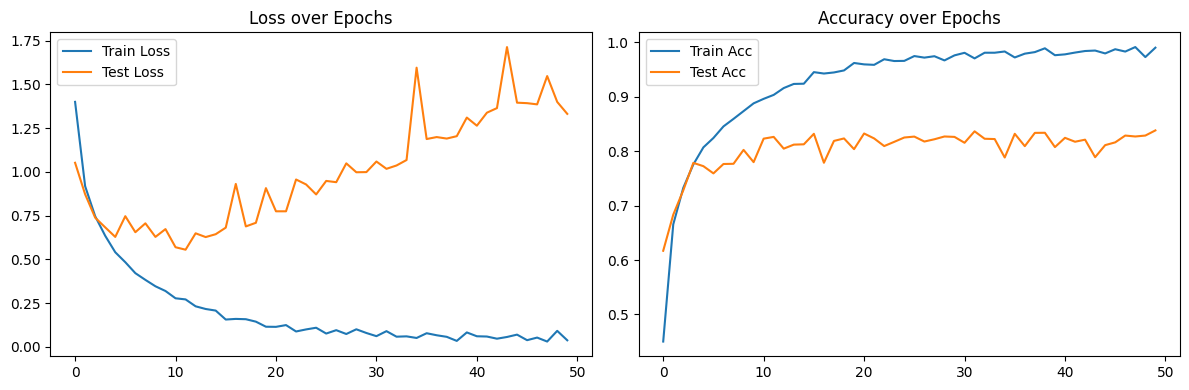

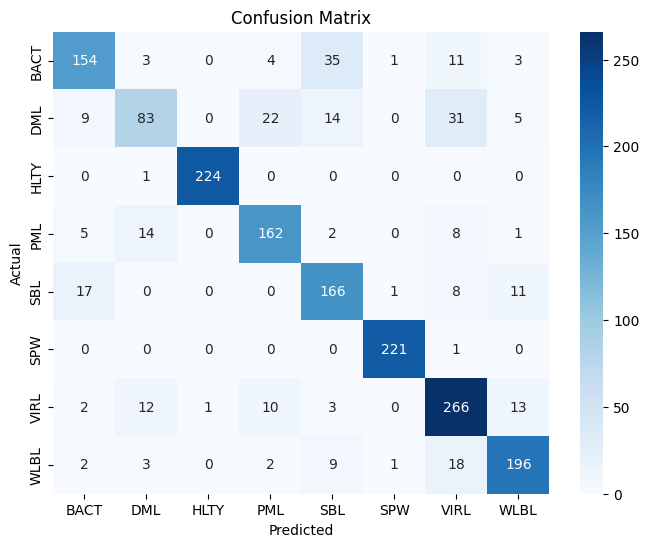

In [ ]:
import mlflow
import mlflow.pytorch
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Start MLflow run
with mlflow.start_run(run_name="TinyVGG-Classifier"):

    # Log model configuration
    mlflow.log_params(
        {
            "model_architecture": "TinyVGG",
            "hidden_units": 10,
            "optimizer": "Adam",
            "learning_rate": 0.001,
            "epochs": NUM_EPOCHS,
            "loss_function": "CrossEntropyLoss",
        }
    )

    # Start training
    start_time = timer()

    model_0_results = train(
        model=model_0,
        train_dataloader=train_dataloader_simple,
        test_dataloader=test_dataloader_simple,
        optimizer=optimizer,
        loss_fn=loss_fn,
        epochs=NUM_EPOCHS,
    )

    end_time = timer()
    print(f"⏱️ Total training time: {end_time-start_time:.3f} seconds")
    mlflow.log_metric("training_time", end_time - start_time)

    # Log training metrics per epoch
    for epoch in range(NUM_EPOCHS):
        mlflow.log_metric(
            "train_loss", model_0_results["train_loss"][epoch], step=epoch
        )
        mlflow.log_metric("train_acc", model_0_results["train_acc"][epoch], step=epoch)
        mlflow.log_metric("test_loss", model_0_results["test_loss"][epoch], step=epoch)
        mlflow.log_metric("test_acc", model_0_results["test_acc"][epoch], step=epoch)

    # Save model to MLflow
    mlflow.pytorch.log_model(model_0, artifact_path="model")

    # Optionally log accuracy/loss curves
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(model_0_results["train_loss"], label="Train Loss")
    ax[0].plot(model_0_results["test_loss"], label="Test Loss")
    ax[0].set_title("Loss over Epochs")
    ax[0].legend()

    ax[1].plot(model_0_results["train_acc"], label="Train Acc")
    ax[1].plot(model_0_results["test_acc"], label="Test Acc")
    ax[1].set_title("Accuracy over Epochs")
    ax[1].legend()

    plt.tight_layout()
    plt.savefig("learning_curves.png")
    mlflow.log_artifact("learning_curves.png")

    # --- Add Confusion Matrix and ROC/AUC if needed ---
    model_0.eval()
    all_preds, all_labels = [], []

    with torch.inference_mode():
        for X_batch, y_batch in test_dataloader_simple:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model_0(X_batch)
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)

            all_preds.extend(y_pred_class.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=train_data.classes,
        yticklabels=train_data.classes,
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

    # Classification Report
    cls_report = classification_report(
        all_labels, all_preds, target_names=train_data.classes, output_dict=True
    )
    for class_name, metrics in cls_report.items():
        if isinstance(metrics, dict):
            for metric_name, score in metrics.items():
                mlflow.log_metric(f"{class_name}_{metric_name}", score)

    # Optionally, log ROC-AUC (multiclass averaged)
    try:
        y_true_bin = np.eye(len(train_data.classes))[all_labels]
        y_score_bin = np.eye(len(train_data.classes))[all_preds]
        auc_score = roc_auc_score(y_true_bin, y_score_bin, average="macro")
        mlflow.log_metric("macro_roc_auc", auc_score)
    except:
        print("⚠️ ROC AUC couldn't be calculated for this multiclass data.")

In [49]:
# Check the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

### 8.1 How to deal with overfitting

Since the main problem with overfitting is that your model is fitting the training data *too well*, you'll want to use techniques to "reign it in".

A common technique of preventing overfitting is known as [**regularization**](https://ml-cheatsheet.readthedocs.io/en/latest/regularization.html).

I like to think of this as "making our models more regular", as in, capable of fitting *more* kinds of data.

Let's discuss a few methods to prevent overfitting.

| **Method to prevent overfitting** | **What is it?** |
| ----- | ----- |
| **Get more data** | Having more data gives the model more opportunities to learn patterns, patterns which may be more generalizable to new examples. | 
| **Simplify your model** | If the current model is already overfitting the training data, it may be too complicated of a model. This means it's learning the patterns of the data too well and isn't able to generalize well to unseen data. One way to simplify a model is to reduce the number of layers it uses or to reduce the number of hidden units in each layer. | 
| **Use data augmentation** | [**Data augmentation**](https://developers.google.com/machine-learning/glossary#data-augmentation) manipulates the training data in a way so that's harder for the model to learn as it artificially adds more variety to the data. If a model is able to learn patterns in augmented data, the model may be able to generalize better to unseen data. |
| **Use transfer learning** | [**Transfer learning**](https://developers.google.com/machine-learning/glossary#transfer-learning) involves leveraging the patterns (also called pretrained weights) one model has learned to use as the foundation for your own task. In our case, we could use one computer vision model pretrained on a large variety of images and then tweak it slightly to be more specialized for food images. |
| **Use dropout layers** | Dropout layers randomly remove connections between hidden layers in neural networks, effectively simplifying a model but also making the remaining connections better. See [`torch.nn.Dropout()`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) for more. | 
| **Use learning rate decay** | The idea here is to slowly decrease the learning rate as a model trains. This is akin to reaching for a coin at the back of a couch. The closer you get, the smaller your steps. The same with the learning rate, the closer you get to [**convergence**](https://developers.google.com/machine-learning/glossary#convergence), the smaller you'll want your weight updates to be.  |
| **Use early stopping** | [**Early stopping**](https://developers.google.com/machine-learning/glossary#early_stopping) stops model training *before* it begins to overfit. As in, say the model's loss has stopped decreasing for the past 10 epochs (this number is arbitrary), you may want to stop the model training here and go with the model weights that had the lowest loss (10 epochs prior). |


### 8.2 How to deal with underfitting 

When a model is [**underfitting**](https://developers.google.com/machine-learning/glossary#underfitting) it is considered to have poor predictive power on the training and test sets.

In essence, an underfitting model will fail to reduce the loss values to a desired level.

Right now, looking at our current loss curves, I'd considered our `TinyVGG` model, `model_0`, to be underfitting the data.

The main idea behind dealing with underfitting is to *increase* your model's predictive power.

There are several ways to do this.

| **Method to prevent underfitting** | **What is it?** |
| ----- | ----- |
| **Add more layers/units to your model** | If your model is underfitting, it may not have enough capability to *learn* the required patterns/weights/representations of the data to be predictive. One way to add more predictive power to your model is to increase the number of hidden layers/units within those layers. | 
| **Tweak the learning rate** | Perhaps your model's learning rate is too high to begin with. And it's trying to update its weights each epoch too much, in turn not learning anything. In this case, you might lower the learning rate and see what happens. |
| **Use transfer learning** | Transfer learning is capable of preventing overfitting and underfitting. It involves using the patterns from a previously working model and adjusting them to your own problem. |
| **Train for longer** | Sometimes a model just needs more time to learn representations of data. If you find in your smaller experiments your model isn't learning anything, perhaps leaving it train for a more epochs may result in better performance. |
| **Use less regularization** | Perhaps your model is underfitting because you're trying to prevent overfitting too much. Holding back on regularization techniques can help your model fit the data better. |

## 9. Model 1: TinyVGG with Data Augmentation

Time to try out another model!

This time, let's load in the data and use **data augmentation** to see if it improves our results in anyway.

First, we'll compose a training transform to include `transforms.TrivialAugmentWide()` as well as resize and turn our images into tensors.

We'll do the same for a testing transform except without the data augmentation.

### 9.1 Create transform with data augmentation

In [ ]:
# Create training transform with TrivialAugment
train_transform_trivial_augment = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.TrivialAugmentWide(num_magnitude_bins=31),
        transforms.ToTensor(),
    ]
)

# Create testing transform (no data augmentation)
test_transform = transforms.Compose(
    [transforms.Resize((64, 64)), transforms.ToTensor()]
)



Now let's turn our images into `Dataset`'s using `torchvision.datasets.ImageFolder()` and then into `DataLoader`'s with `torch.utils.data.DataLoader()`.

### 9.2 Create train and test `Dataset`'s and `DataLoader`'s

We'll make sure the train `Dataset` uses the `train_transform_trivial_augment` and the test `Dataset` uses the `test_transform`.

In [ ]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(
    train_dir, transform=train_transform_trivial_augment
)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 7002
     Root location: F:\Lettuce_leaf_classification\DNN_dataloader\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 1755
     Root location: F:\Lettuce_leaf_classification\DNN_dataloader\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [ ]:
# Turn Datasets into DataLoader's
import os

BATCH_SIZE = 16
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(
    train_data_augmented, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS
)

test_dataloader_simple = DataLoader(
    test_data_simple, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
)

train_dataloader_augmented, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x16b6c43abc0>,
 <torch.utils.data.dataloader.DataLoader at 0x16b6859a830>)

### 9.3 Construct and train Model 1

Data loaded!

Now to build our next model, `model_1`, we can reuse our `TinyVGG` class from before. 

We'll make sure to send it to the target device.

In [57]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(
    input_shape=3, hidden_units=10, output_shape=len(train_data_augmented.classes)
).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=8, bias=True)
  )
)

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 50

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer

start_time = timer()

# Train model_1
model_1_results = train(
    model=model_1,
    train_dataloader=train_dataloader_augmented,
    test_dataloader=test_dataloader_simple,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=NUM_EPOCHS,
)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

In [ ]:
import mlflow
import mlflow.pytorch
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Set number of epochs
NUM_EPOCHS = 50
# Start MLflow run
with mlflow.start_run(run_name="TinyVGG-Classifier-Aug_model1"):

    # Log model configuration
    mlflow.log_params(
        {
            "model_architecture": "TinyVGG",
            "hidden_units": 10,
            "optimizer": "Adam",
            "learning_rate": 0.001,
            "epochs": NUM_EPOCHS,
            "loss_function": "WeightedCrossEntropyLoss",
        }
    )

    # Start training
    start_time = timer()

    model_1_results = train(
        model=model_1,
        train_dataloader=train_dataloader_simple,
        test_dataloader=test_dataloader_simple,
        optimizer=optimizer,
        loss_fn=loss_fn,
        epochs=NUM_EPOCHS,
    )

    end_time = timer()
    print(f"⏱️ Total training time: {end_time-start_time:.3f} seconds")
    mlflow.log_metric("training_time", end_time - start_time)

    # Log training metrics per epoch
    for epoch in range(NUM_EPOCHS):
        mlflow.log_metric(
            "train_loss", model_1_results["train_loss"][epoch], step=epoch
        )
        mlflow.log_metric("train_acc", model_1_results["train_acc"][epoch], step=epoch)
        mlflow.log_metric("test_loss", model_1_results["test_loss"][epoch], step=epoch)
        mlflow.log_metric("test_acc", model_1_results["test_acc"][epoch], step=epoch)

    # Save model to MLflow
    mlflow.pytorch.log_model(model_1, artifact_path="model")

    # Optionally log accuracy/loss curves
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(model_1_results["train_loss"], label="Train Loss")
    ax[0].plot(model_1_results["test_loss"], label="Test Loss")
    ax[0].set_title("Loss over Epochs")
    ax[0].legend()

    ax[1].plot(model_1_results["train_acc"], label="Train Acc")
    ax[1].plot(model_1_results["test_acc"], label="Test Acc")
    ax[1].set_title("Accuracy over Epochs")
    ax[1].legend()

    plt.tight_layout()
    plt.savefig("learning_curves.png")
    mlflow.log_artifact("learning_curves.png")

    # --- Add Confusion Matrix and ROC/AUC if needed ---
    model_1.eval()
    all_preds, all_labels = [], []

    with torch.inference_mode():
        for X_batch, y_batch in test_dataloader_simple:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model_1(X_batch)
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)

            all_preds.extend(y_pred_class.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=train_data.classes,
        yticklabels=train_data.classes,
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

    # Classification Report
    cls_report = classification_report(
        all_labels, all_preds, target_names=train_data.classes, output_dict=True
    )
    for class_name, metrics in cls_report.items():
        if isinstance(metrics, dict):
            for metric_name, score in metrics.items():
                mlflow.log_metric(f"{class_name}_{metric_name}", score)

    # Optionally, log ROC-AUC (multiclass averaged)
    try:
        y_true_bin = np.eye(len(train_data.classes))[all_labels]
        y_score_bin = np.eye(len(train_data.classes))[all_preds]
        auc_score = roc_auc_score(y_true_bin, y_score_bin, average="macro")
        mlflow.log_metric("macro_roc_auc", auc_score)
    except:
        print("⚠️ ROC AUC couldn't be calculated for this multiclass data.")